<h1>SARS-Cov-2 Analysis Workflow</h1>

This tutorial implements the best-practices bioinformatics workflow for the assembly of an SARS-CoV-2 viral genomes. The workflow in the document implements the [ARTIC Nanopore bioinformatics SOP](https://artic.network/ncov-2019/ncov2019-bioinformatics-sop.html).

Computational requirements for this tutorial include:

- Computer running the **EPI2ME Labs** notebook Server
- At least 16 Gb RAM
- An internet connection

## Getting Started

Before anything else we will create and set a working directory:

In [20]:
from epi2melabs import ping
tutorial_name = 'ncov_tutorial'
pinger = ping.Pingu()
pinger.send_notebook_ping('start', tutorial_name)

# create a work directory and move into it
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/ncov_tutorial


### Install additional software

The default **EPI2MELabs** environment does not contain the ARTIC software. In this section we will prepare the enviroment with the necessary ARTIC software installation.

*Please note that the software installed is not persistent and this step will need to be re-run if you stop and restart the EPI2ME Labs server*

Having connected to the EPI2ME Labs Server, we will install the necessary software. Press the play button below to the left hand side (it may appear as `[ ]`):

In [ ]:
#ARTIC Bioinformatics installation (click the play button to install)
import os
%cd "$working_dir"
if os.path.exists("artic-ncov2019"):
    print("Found existing install, removing.")
    !rm -rf artic-ncov2019
print("Downloading artic-ncov")
# we need this just for primerset data
!git clone https://github.com/artic-network/artic-ncov2019.git
print("Downloading V1200 primer set")
# windows doesn't like that SARS-CoV-2 is a symlink, delete it and move ncov2019
!cd artic-ncov2019/primer_schemes/nCoV-2019 \
    && wget -O 1200bp_amplicon_bed.tar.gz https://zenodo.org/record/3897530/files/1200bp_amplicon_bed.tar.gz?download=1 \
    && tar -xf 1200bp_amplicon_bed.tar.gz

# install artic analysis pipeline
if os.path.exists("fieldbioinformatics"):
    print("Found existing install, removing.")
    !rm -rf fieldbioinformatics
!git clone https://github.com/artic-network/fieldbioinformatics
%cd fieldbioinformatics
!git checkout 1.2.1
!conda env remove -n artic
!mamba env create -q -f environment.yml
!. /opt/conda/etc/profile.d/conda.sh \
    && conda activate artic \
    && pip install -q . && pip install -q ipykernel
!echo
!echo "Testing install (version should be displayed below)"
!run artic --version

%cd "$working_dir"

### Sample Data

This tutorial is provided with a sample dataset. Samples included in the demonstration dataset were obtained from European Nucleotide Archive project [PRJNA650037](https://www.ebi.ac.uk/ena/browser/view/PRJNA650037). This project has the title Johns Hopkins Viral Genomics of Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) and describes 210 virus samples that have been sequenced according to the ARTIC protocol on a GridION device. Ten samples with unique barcodes in the range 1..12 were picked from this project for this demonstration dataset.

To download the sample file we run the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

!wget -O sars-samples.tar.gz "$site/ncov_tutorial/sars-samples.tar.gz"
print("Extracting data...")
!rm -rf sars-samples
!tar -xzf sars-samples.tar.gz
print("Done.")

# a second larger sample dataset is also available for testing
#!wget -O 96samples.tar.bz2 "$site/ncov_tutorial/96samples.tar.bz2"
#print("Extracting data...")
#!rm -rf 180min
#!tar -xjf 96samples.tar.bz2
#!mv 180min 96samples
#print("Done.")

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value of the `input_file` variable below. To find the correct full path of a file you can navigate to it in the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

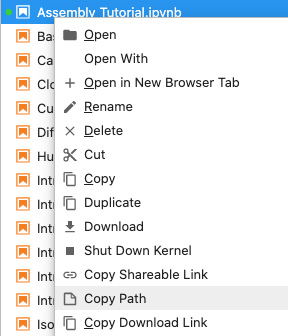

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.

### Data Entry

The workflow requires `.fastq` files from an Oxford Nanopore Technologies' sequencing device. The workflow will, by default, demultiplex the reads. This step can be skipped if the reads have already been demultiplexed by MinKNOW or Guppy from the options below.


The input folder should be a folder containing one or more `.fastq` files, such as the `fastq_pass` folder output by MinKNOW (or Guppy).

In [ ]:
# Input data
import os
import shutil

import ipywidgets as widgets

from epi2melabs import notebook

input_folder = None
recursive = None
output_folder = None 
run_name = None
overwrite = None

def process_form(inputs):
    global input_folder, resursive, output_folder, run_name, overwrite
    input_folder = inputs.input_folder
    recursive = inputs.recursive
    output_folder = inputs.output_folder
    run_name = inputs.run_name
    overwrite = inputs.overwrite

    success = True
    msg_lines = []

    # check input folder
    !cecho ok "Checking input folder"
    if not os.path.exists(input_folder):
        print(notebook.error(" - `{}` does not exist.".format(input_folder)))
        return
    else:
        msg = "Input folder:  {}".format(input_folder)
        print(notebook.success(msg))

    # check output
    !cecho ok "Checking output folder"
    if os.path.exists(output_folder) and not overwrite:
        msg = " - `{}` exists, overwrite not selected".format(output_folder)
        print(notebook.error(msg))
        return
    else:
        if os.path.exists(output_folder):
            print(notebook.ok(" - Previous output folder exists, removing"))
            try:
                shutil.rmtree(output_folder)
            except:
                print(notebook.error(' - Error while deleting directory'))
                return
        os.mkdir(output_folder)
        msg = "Output folder: {}".format(output_folder)
        print(notebook.success(msg))

input_form = notebook.InputForm(
    notebook.InputSpec('input_folder', 'Input folder', "/epi2melabs/ncov_tutorial/sars-samples"),
    notebook.InputSpec('recursive', 'Recursive input search', False),
    notebook.InputSpec('output_folder', 'Output folder', "/epi2melabs/ncov_tutorial/analysis/"),
    notebook.InputSpec('run_name', 'Run name', 'run0'),
    notebook.InputSpec('overwrite', 'Overwrite existing', False),
    description_width='200px'
)
input_form.add_process_button(process_form)
input_form.display()

The form below can be used to change the analysis parameters from their defaults.

If your input directory contains reads which have already been demultiplexed, select the "Skip demultiplexing" option. You should still however select the an appropriate barcode arrangements setting (either 12/24- or 96-barcodes)

The default minimum and maximum read lengths are appropriate for the ARTIC 400mer applicon sets, and experiment using alterative amplicon scheme (e.g. the V1200 scheme) should change these values.

In [ ]:
# Input analysis parameters
import glob
import multiprocessing
import os
import shutil

import ipywidgets as widgets

import aplanat.report
from epi2melabs import notebook

debug = True
ref_name = "MN908947.3"
ref_len = 29903

threads = None
primer_set = None
minimum_reads = None
min_read_length = None
max_read_length = None
barcode_arrangements = None
require_both_ends = None
skip_demultiplexing = None
seq_summary_file = None
medaka_model = None
report = None

!run medaka tools list_models > medaka_models.txt
model_keys = {'Available', 'Default consensus'}
models = dict()
with open("medaka_models.txt") as fh:
    for line in fh.readlines():
        for model_key in model_keys:
            key, items = line.split(":")
            mods = [m.strip() for m in items.split(",")]
            models[key] = [m for m in mods if (('snp' not in m) and ('variant' not in m))]

def process_form(inputs):
    global threads, \
        primer_set, minimum_reads, min_read_length, max_read_length, \
        barcode_arrangements, require_both_ends, skip_demultiplexing, \
        seq_summary_file, medaka_model, report
    threads = inputs.threads
    primer_set = inputs.primer_set
    minimum_reads = inputs.minimum_reads
    #min_read_length = inputs.min_read_length
    #max_read_length = inputs.max_read_length
    barcode_arrangements = inputs.barcode_arrangements
    skip_demultiplexing = inputs.skip_demultiplexing
    medaka_model = inputs.medaka_model

    if "V1200" in primer_set:
        min_read_length, max_read_length = 150, 1200
    else:
        min_read_length, max_read_length = 400, 700
    if "barcode_arrs_nb" in barcode_arrangements:
        require_both_ends = "--require_barcodes_both_ends"
    else:
        require_both_ends = ""

    text = """
    ###Analysis Parameters

        input: {}
        primer set: {}
        minimum reads: {}
        min. read length: {}
        max. read length: {}
        barcode arrangements: {}
    """.format(
        input_folder, primer_set, minimum_reads, min_read_length, max_read_length,
        barcode_arrangements)
    print(text.replace('###', ''))
    report = aplanat.report.HTMLReport(
        "SARS-Cov-2 Analysis",
        "EPI2MELabs summary report for: {}.".format(run_name),
        require_keys = True)
    report.markdown(text, key="simple preamble")

primers = ["nCoV-2019/{}".format(v) for v in ("V1", "V2", "V3", "V1200")]
input_form = notebook.InputForm(
    notebook.InputSpec('threads', 'Compute threads', (1, multiprocessing.cpu_count())),
    notebook.InputSpec('primer_set', 'Primer set', widgets.Dropdown(options=primers, value="nCoV-2019/V3")),
    notebook.InputSpec('minimum_reads', 'Minimum reads', widgets.IntText(10000)),
    #notebook.InputSpec('min_read_length', 'Minimum read length', widgets.IntText(400)),
    #notebook.InputSpec('max_read_length', 'Maximum read length', widgets.IntText(700)),
    notebook.InputSpec(
        'barcode_arrangements', 'Barcode arrangement file',
        widgets.Dropdown(
            options=[
                'barcode_arrs_nb12.cfg',
                'barcode_arrs_nb12.cfg  barcode_arrs_nb24.cfg',
                'barcode_arrs_nb96.cfg',
                'barcode_arrs_rbk096.cfg'])),
    notebook.InputSpec('skip_demultiplexing', 'Skip demultiplexing', False),
    notebook.InputSpec(
        'medaka_model', 'Medaka model name',
        widgets.Dropdown(value=models['Default consensus'][0], options=models['Available'])),
    description_width='200px'
)
input_form.add_process_button(process_form)
input_form.display()

## Analysis

With our software environment set up and our inputs specified it is time to move on the the analysis. The following workflow begins with demultiplexing the reads using strict settings to avoid misidentification, followed by running of the Artic analysis, and finally creation of Quality control plots to determine if tha analysis is valid.

### Demultiplexing and Read Quality Control

In this section we will run sample demultiplexing using the `guppy_barcoder` software. The results of this will appear in the output folder under the `demultiplex` folder. After demultiplexing a report is produced from the demultiplexed `.fastq` data.

> ***In the case of pre-demultiplexed reads, `guppy_barcoder` is skipped and the input folder is searched for outputs of previous demultiplexing***


In [32]:
# **Running demultiplexing** *(press play)*
!rm -rf $output_folder/demultiplex
if skip_demultiplexing:
    !cecho ok "Attempting to find previous demultiplexing results"
    found = 0
    for folder in glob.glob(os.path.join(input_folder, '**barcode*'), recursive=True):
        if os.path.isdir(folder):
            found += 1
            !mkdir -p $output_folder/demultiplex
            !cp -r $folder $output_folder/demultiplex
    if found > 0:
        !cecho success "Found $found barcode folders"
    else:
        !cecho error "Did not find any previous demultiplexing results. The input folder sub contain subfolders of named `barcodeXX`."
else:
    rec = "--recursive" if recursive else ""
    !guppy_barcoder \
        --require_barcodes_both_ends --arrangements_files "$barcode_arrangements" \
        --compress_fastq --records_per_fastq 0 $rec --worker_threads $threads \
        --save_path $output_folder/demultiplex \
        --input_path $input_folder \
        && cecho success "Guppy finished successfully" \
        || cecho error "Guppy failed"


ONT Guppy barcoding software version 4.2.2+effbaf8
input path:         /epi2melabs/ncov_tutorial/sars-samples
save path:          /epi2melabs/ncov_tutorial/analysis//demultiplex
arrangement files:  barcode_arrs_nb12.cfg
lamp arr. files:    barcode_arrs_lamp8.cfg barcode_arrs_lamp96.cfg
min. score front:   60
min. score rear:    60


Found 10 fastq files.

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Done in 140174 ms.
Guppy finished successfully


The demultiplexing produces a summary file recording the barcode found in each read, or "unclassified" if the barcodes could not be confidently identified.

In [35]:
# Merging data files (press play)

import pandas as pd
import pysam
import numpy as np
from tqdm.notebook import tqdm

def mean_qual(quals):
    """Calculate mean quality score of a read."""
    qual = np.fromiter(
        (ord(x) - 33 for x in quals),
        dtype=int, count=len(quals))
    mean_p = np.mean(np.power(10, qual / -10))
    return -10 * np.log10(mean_p)

print(notebook.ok("Creating read summary from .fastq data."))

def get_read_lengths(fname):
    data = []
    barcode = os.path.basename(os.path.dirname(fname))
    if not (barcode.startswith('barcode') or barcode == 'unclassified'):
        raise ValueError('.fastq data found in a folder named "barcode*".')
    for read in pysam.FastxFile(fname):
        data.append("{}\t{}\t{}\t{}\n".format(read.name, barcode, len(read.sequence), mean_qual(read.quality)))
    data = ''.join(data)
    return data

fastqs = glob.glob(os.path.join(output_folder, "demultiplex/**", "*.fastq*"))
print(notebook.ok(" - Found {} files.".format(len(fastqs))))
seq_summary_file = os.path.join(output_folder, "read_lengths.txt")
try:
    with open(seq_summary_file, "w") as fh:
        fh.write("read_id\tbarcode_arrangement\tsequence_length_template\tread_quality\n")
        #for results in map(get_read_lengths, fastqs):
        #    fh.write(results)
        with tqdm(total=len(fastqs)) as progress:
            for results in map(get_read_lengths, fastqs):
                fh.write(results)
                progress.update(1)
except Exception as e:
    print(notebook.error(" - Failed to create sequence summary."))
else:
    print(notebook.success(" - Created sequence summary."))
    seq_summary = pd.read_csv(seq_summary_file, "\t")


Creating read summary from .fastq data.
 - Found 11 files.


  0%|          | 0/11 [00:00<?, ?it/s]

 - Created sequence summary.


To generate a QC report, run the cell below:



In [36]:
# Reads QC Report (press play)
import aplanat
from aplanat import bars, hist, annot
from aplanat.util import Colors
from bokeh.models import Span
from bokeh.layouts import gridplot
import pandas as pd 
import numpy as np


plots = list()

total_bases = seq_summary['sequence_length_template'].sum()
mean_length = total_bases / len(seq_summary)
median_length = np.median(seq_summary['sequence_length_template'])

# read length plot
datas = [seq_summary['sequence_length_template']]
length_hist = hist.histogram(
    datas, bins=400,
    title="Read length distribution.",
    x_axis_label='Read Length / bases',
    y_axis_label='Number of reads',
    colors = [Colors.cerulean],
    xlim=(0, 2000))
length_hist = annot.marker_vline(
    length_hist, min_read_length,
    label="Min: {}".format(min_read_length), text_baseline='bottom', color='grey')
length_hist = annot.marker_vline(
    length_hist, max_read_length,
    label="Max: {}".format(max_read_length), text_baseline='top')
length_hist = annot.subtitle(
    length_hist,
    "Mean: {:.0f}. Median: {:.0f}".format(
        mean_length, median_length))
plots.append(length_hist)

datas = [seq_summary['read_quality']]
mean_q, median_q = np.mean(datas[0]), np.median(datas[0])
q_hist = hist.histogram(
        datas, colors=[Colors.cerulean], bins=100,
        title="Read quality score",
        x_axis_label="Quality score",
        y_axis_label="Number of reads",
        xlim=(4, 25))
q_hist = annot.subtitle(
        q_hist,
        "Mean: {:.0f}. Median: {:.0f}".format(
            mean_q, median_q))

plots.append(q_hist)

# barcode count plot
good_reads = seq_summary.loc[
    (seq_summary['sequence_length_template'] > min_read_length)
    & (seq_summary['sequence_length_template'] > min_read_length)]
barcode_counts = (
    pd.DataFrame(good_reads['barcode_arrangement'].value_counts())
    .sort_index()
    .reset_index()
    .rename(
        columns={'index':'barcode', 'barcode_arrangement':'count'})
    )
bc_counts = bars.simple_bar(
    barcode_counts['barcode'], barcode_counts['count'], colors=Colors.cerulean,
    title='Number of reads per barcode (filtered by {} < length < {})'.format(min_read_length, max_read_length))
bc_counts = annot.subtitle(
    bc_counts,
    'Barcodes with fewer than {} reads will not be analysed further.'.format(
        minimum_reads))
bc_counts.xaxis.major_label_orientation = 3.14/2
bc_counts = annot.marker_hline(bc_counts, minimum_reads)
plots.append(bc_counts)

# determine which barcode datasets are good
barcode_counts['sufficient data'] = barcode_counts['count'] > minimum_reads
valid_barcodes = set(
    barcode_counts.loc[barcode_counts['sufficient data']]['barcode'])

plots = gridplot(plots, ncols=2)

report.markdown("""
### Read Quality Control

The following depicts reads remaining after barcode demultiplexing.
""", key="qc_header")
report.plot(plots, key="qc_plots")
aplanat.show(plots, background="#f4f4f4")

### Run ARTIC for each sample

With demultiplexed reads, we are in a position to analyse each dataset independently using the ARTIC workflow.

In [ ]:
# Run ARTIC analysis for each barcode (press play)
def run_artic(
        barcode, directory, artic_output,
        min_len=400, max_len=700, run_name="run0", threads=8,
        scheme="V3"):
    !mkdir -p $artic_output/$barcode
    prefix = os.path.join(artic_output, barcode, run_name)
    log_file = "{}_artic.log".format(prefix)
    read_file = "{}_{}.fastq".format(prefix, barcode)
    print("Writing log file to: {}.".format(log_file))
    # read filtering
    !cecho ok "Running artic guppyplex to filter reads"
    !echo "=== Start of 'artic guppyplex' log" >> $log_file
    !run artic guppyplex --skip-quality-check \
        --min-length $min_len --max-length $max_len \
        --directory $directory --prefix $prefix >>$log_file 2>&1 \
        && echo " - artic guppyplex finished"
    # run everything else
    !cecho ok "Running artic minion --medaka to call variants"
    !echo "=== Start of 'artic minion' log" >> $log_file
    !run artic minion --medaka --normalise 200 --threads $threads \
        --scheme-directory $working_dir/artic-ncov2019/primer_schemes \
        --read-file $read_file $scheme \
        --medaka-model $medaka_model \
        $prefix >>$log_file 2>&1 \
        && echo " - artic minion finished"
    !cecho ok "Running alignment QC"
    !echo "=== Start of 'alignment QC' log" >> $log_file
    for i in (1,2):
        input_bam = "{}.primertrimmed.rg.sorted.bam".format(prefix)
        tag = "nCoV-2019_{}".format(i)
        bam = "{}.{}".format(input_bam, tag)
        if os.path.isfile(input_bam):
            !samtools view -r $tag -b $input_bam > $bam
            !samtools index $bam
            !stats_from_bam $bam > $bam".stats"
            !coverage_from_bam -s 50 -p $bam $bam
            !rm -rf $bam $bam.bai
        else:
            !echo error " - No Artic output bam file found for primer set $i, Artic failed."
    return prefix

# setup artic output
print(output_folder)
artic_output = os.path.join(output_folder, "artic")

# run analysis for each barcode
valid_barcodes = [
    x for x in barcode_counts.loc[barcode_counts['sufficient data']]['barcode']
    if x != "unclassified"]
print(notebook.warning("Running Artic for:"))
for barcode in valid_barcodes:
    print("   {}".format(barcode))
print()
for barcode in valid_barcodes:
    msg = "Running ARTIC analysis for: {}".format(barcode)
    print(notebook.warning(msg))
    print(notebook.warning("-" * len(msg)))
    print()
    artic_input = os.path.join(output_folder, "demultiplex", barcode)
    !rm -rf $artic_output/$barcode
    out_prefix = run_artic(
        barcode, artic_input, artic_output,
        min_len=min_read_length, max_len=max_read_length, run_name=run_name, 
        threads=threads, scheme=primer_set)
    print("Results for {} can be found at {}".format(barcode, out_prefix))
    msg = "ARTIC finished for: {}".format(barcode)
    print(msg)
    print("=" * len(msg))
    print()

The ARTIC worflow produces the following files for each barcode (*\<run_name>* is the value given at the top of this page):

1. `<run_name>.rg.primertrimmed.bam` - BAM file for visualisation after primer-binding site trimming
2. `<run_name>.trimmed.bam` - BAM file with the primers left on (used in variant calling)
3. `<run_name>.merged.vcf` - all detected variants in VCF format
4. `<run_name>.pass.vcf.gz` - detected variants in VCF format passing quality filter
5. `<run_name>.fail.vcf` - detected variants in VCF format failing quality filter
6. `<run_name>.primers.vcf` - detected variants falling in primer-binding regions
7. `<run_name>.consensus.fasta` - consensus sequence

These will be present in folders named as:

    <output_folder>/analysis/artic/<barcode>/

where `<output_folder>` is the value given at the top of this page and `<barcode>` is the identified barcode for each dataset.

### Consensus sequences

The artic workflow does not collate all consensus sequences from each barcode together. To do this run the codecell below. You will be given the opportunity to provide meaningful names to each sample if desired. These sequences can be uploaded to [nextclade](https://clades.nextstrain.org/) for further analysis, or submitted to [GISAID](https://www.gisaid.org/).


In [ ]:
# Outputting consensus sequences to FASTA *(click play)*
from IPython.display import FileLink

pinger.send_notebook_ping('stop', tutorial_name)
consensuses = glob.glob("analysis/artic/barcode*/{}.consensus.fasta".format(run_name))

def process_files(inputs):
    collated = os.path.abspath("all_artic_consensus.fasta")
    !rm -rf $collated
    for consensus in consensuses:
        barcode = os.path.basename(os.path.dirname(consensus))
        name = getattr(inputs, barcode)
        !sed "s/^>.*/>$name/" $consensus >> $collated
    print("Collated sequences written to:")
    display(FileLink(collated, url_prefix="/files/"))

inputs = list()
for con in consensuses:
    barcode = os.path.basename(os.path.dirname(con))
    inputs.append(notebook.InputSpec(barcode, "Sample name for {}:".format(barcode), "{}_{}".format(run_name, barcode)))
    
cons_form = notebook.InputForm(*inputs, description_width="200px")
cons_form.add_process_button(process_files)
cons_form.display()

#### Artic Analysis Status success/failed

A check to see how many samples passed or failed to produce results from the primary ARTIC analysis.

In [39]:
# Success/Failed analysis
from bokeh.models import Panel, Range1d, Tabs

!grep "^>" all_artic_consensus.fasta \
        | awk 'BEGIN{OFS="\t"; print "sample\tpass"}{print substr($1, 2), $2!="Artic-Fail"}' > pass_fail.txt

status = pd.read_csv('pass_fail.txt', sep='\t')
failed = status.loc[status['pass'] == 0]
if len(failed) == 0:
        fail_list = "All samples analysed successfully"
else:
        fail_list = failed['sample'].str.cat(sep=', ')
fail_percentage = int(100 * len(failed) / len(status))
classes = ['Success', 'Analysis Failed']
values = [100 - fail_percentage, fail_percentage]
colors = ['#54B8B1', '#EF4135']
plot = bars.single_hbar(
values, classes, colors,
        title="Completed analyses",
        x_axis_label="%age Samples")
plot.x_range = Range1d(0, 140)
print(fail_list)
aplanat.show(plot)
report.markdown("""
#### Artic analysis status
The panel below lists samples which failed to produce results from the primary ARTIC analysis.
Samples not listed here were analysed successfully, but may still contain inconclusive or invalid results.
See the following sections for further indications of failed or inconclusive results.
""",
    key="pass-fail-head")
report.markdown("""
```{}```
""".format(fail_list),key="pass-fail-list")
report.plot(plot,key="pass-fail-plot")

All samples analysed successfully


#### Brief summary of results

Running the below will produce a simple tabular summary for each barcoded dataset.

In [40]:
# ARTIC Summary Table (click play)
from collections import Counter, defaultdict
import gzip
from pysam import FastxFile
from Bio import SeqIO

if "96" in barcode_arrangements:
    max_bc = 96
elif "24" in barcode_arrangements:
    max_bc = 24
else:
    max_bc = 12

!cecho ok "The tables below assume you are using up to $max_bc barcodes (detected from barcoding arrangement files)."

artic_output = os.path.join(output_folder, "artic")
results = defaultdict(dict)
for barcode in ('barcode{:02}'.format(x) for x in range(1, max_bc + 1)):
    results[barcode]["Ns"] = 'NA'
    results[barcode]['variants'] = 'NA'
    if not barcode in valid_barcodes:
        continue
    consensus_file = os.path.join(
        artic_output, barcode, "{}.consensus.fasta".format(run_name))
    vcf_file = os.path.join(
        artic_output, barcode, "{}.pass.vcf.gz".format(run_name))
    recs = 0
    try:
        for record in SeqIO.parse(consensus_file, "fasta"):
            recs += 1
            results[barcode]["Ns"] = record.seq.count("N")
    except FileNotFoundError as e:
        !cecho error "ARTIC pipeline failed to produce consensus.fasta file for $barcode"
        continue
    else:
        if recs != 1:
            !cecho error "ARTIC pipeline produced one than one consensus contig for $barcode"
            continue
    variants = 0
    with gzip.open(vcf_file) as vcf:
        for line in (x.decode() for x in vcf):
            if line.startswith('#'):
                continue
            variants += 1
    results[barcode]['variants'] = variants

df = pd.DataFrame.from_dict(results)
df.columns = ['bc{:02}'.format(x) for x in range(1, max_bc + 1)]
parts = [
    ['bc{:02}'.format(x) for x in range(start, start + 12)]
    for start in range(1, max_bc + 1, 12)]
report.markdown("""
### Per barcode results

The variants discovered per barcode were as follows. `NA` indicated the barcode
was not present, or that too few reads were obtained for analysis to be performed.
""", key="results_header")
for i, p in enumerate(parts):
    display(df[p])
    report.table(df[p], key="summary_pt{}".format(i))

The tables below assume you are using up to 12 barcodes (detected from barcoding arrangement files).


,bc01,bc02,bc03,bc04,bc05,bc06,bc07,bc08,bc09,bc10,bc11,bc12
Ns,121,121,121,NA,339,123,510,121,121,121,NA,121
variants,7,7,6,NA,8,7,8,6,9,8,NA,8


### QC Summary of ARTIC pipeline results

The results of the ARTIC pipeline include alignment of the reads to a reference genome. A summary of these alignments is produced by the section below. Things to look for here include even coverage of amplicons and that the negative control sample shows little to no data.

In [41]:
# Collate ARTIC alignment statistics (press play)
from aplanat import lines
from aplanat import util

bam_name = ".primertrimmed.rg.sorted.bam.nCoV-2019_{}"
cover_suffix = "_{}_0_{}.depth.txt".format(ref_name, ref_len)
stats_suffix = ".stats"

dfs_cover = list()
dfs_stats = list()
for barcode in valid_barcodes:
    stats_stem = os.path.join(artic_output, barcode, run_name)
    for i in (1,2):
        df = pd.read_csv(stats_stem + bam_name.format(i) + cover_suffix, sep='\t')
        df['primer_set'] = i
        df['barcode'] = barcode
        dfs_cover.append(df)
        df = pd.read_csv(stats_stem + bam_name.format(i) + stats_suffix, sep='\t')
        df['primer_set'] = i
        df['barcode'] = barcode
        dfs_stats.append(df)
cover_summary = pd.concat(dfs_cover)
stats_summary = pd.concat(dfs_stats)
dfs_cover, dfs_stats = None, None
print("Finished collating data")

Finished collating data


With the summary data collated we can plot coverage histograms for all barcoded samples, across primer pools or by read orientation. Use the tabs to switch between views.

For adequate variant calling depth should be at least 30X in any region.

To better display all possible data, the depth axes of the plots below are not tied between plots for different samples.
Care should be taken in comparing depth across samples.

In [42]:
# Collate and visualise depth summary report

def read_files(summaries, sep='\t'):
    """Read a set of files and join to single dataframe."""
    dfs = list()
    for fname in sorted(summaries):
        dfs.append(pd.read_csv(fname, sep=sep))
    return pd.concat(dfs)

# depth summary by primer pool
df = cover_summary
plots_pool = list()
plots_orient = list()
plots_combined = list()
depth_lim = 100
for sample in sorted(df['barcode'].unique()):
        bc = df['barcode'] == sample
        depth = df[bc].groupby('pos').sum().reset_index()
        depth_thresh = \
        100*(depth['depth'] >= depth_lim).sum() / len(depth['depth'])
        depth_mean = depth['depth'].mean()

            # total depth plot
            # plot line just to get aplanat niceities
        p = lines.line(
                [depth['pos']], [depth['depth']], colors=[Colors.cerulean],
                title="{}: {:.0f}X, {:.1f}% > {}X".format(
                    sample, depth_mean, depth_thresh, depth_lim),
                height=250, width=400,
                x_axis_label='position', y_axis_label='depth',
            )
        p.varea(
                x=depth['pos'], y1=0.1, y2=depth['depth'],
                fill_color=Colors.cerulean)
        plots_combined.append(p)

         # fwd/rev
        xs = [depth['pos'], depth['pos']]
        ys = [depth['depth_fwd'], depth['depth_rev']]
        names = ['fwd', 'rev']
        colors = [Colors.dark_gray, Colors.verdigris]

        p = lines.line(
        xs, ys, colors=colors, names=names,
        title="{}: {:.0f}X, {:.1f}% > {}X".format(
                    sample, depth_mean, depth_thresh, depth_lim),
                height=250, width=350,
        x_axis_label='position', y_axis_label='depth')
        for x, y, name, color in zip(xs, ys, names, colors):
            p.varea(
                x=x, y1=0, y2=y, legend_label=name,
                    fill_color=color, alpha=0.7,
                    muted_color=color, muted_alpha=0.2)
            p.legend.click_policy = 'mute'
            plots_orient.append(p)

        # primer set plot
        pset = df['primer_set']
        xs = [df.loc[(pset == i) & bc]['pos'] for i in (1, 2)]
        ys = [df.loc[(pset == i) & bc]['depth'] for i in (1, 2)]
        names = ['pool-1', 'pool-2']
        colors = [Colors.light_cornflower_blue, Colors.feldgrau]
        
        p = lines.line(
            xs, ys, colors=colors, names=names,
            title="{}: {:.0f}X, {:.1f}% > {}X".format(
            sample, depth_mean, depth_thresh, depth_lim),
            height=250, width=350,
            x_axis_label='position', y_axis_label='depth')
        for x, y, name, color in zip(xs, ys, names, colors):
            p.varea(
                x=x, y1=0, y2=y, legend_label=name,
                fill_color=color, alpha=0.7,
                muted_color=color, muted_alpha=0.2)
            p.legend.click_policy = 'mute'
            plots_pool.append(p)
tab1 = Panel(
            child=gridplot(plots_combined, ncols=3), title="Coverage Plot")
tab2 = Panel(
            child=gridplot(plots_pool[::2], ncols=3), title="By amplicon pool")
tab3 = Panel(
            child=gridplot(plots_orient[::2], ncols=3), title="By read orientation")
cover_panel = Tabs(tabs=[tab1, tab2, tab3])

aplanat.show(cover_panel)
report.markdown("""
### Genome Coverage
Plots below indicate depth of coverage from data used within the Artic analysis
coloured by amplicon pool. For adequate variant calling depth should be at least 30X in any region.


NB: To better display all possible data, the depth axes of the plots below are not tied between plots for different samples.
Care should be taken in comparing depth across samples.
""",
    key="genome-coverage-head")
report.plot(cover_panel,key="genome-coverage")

It can be interesting also to examine the basecalling quality for the different samples and primer pools. This can indicate potential problems in the sequencing library preparation.

In [43]:
# Show basecall accuracies (press play)

plots = list()
df = stats_summary
for barcode in valid_barcodes:
    pset = df['primer_set']
    bc = df['barcode'] == barcode
    try:
        xs, ys = list(), list()
        for i in (1, 2):
            d = df.loc[(pset == i) & bc]
            if len(d) == 0:
                !cecho warning "Warning: No basecalls for $barcode and primer set $i"
                # aplanat can't currently plot empty data
                x, y = [99.9, 100], [0, 0.0001]
            else:
                x, y = util.kernel_density_estimate(d['acc'])
            xs.append(x)
            ys.append(y)
    except:
        pass
    plot = lines.line(
        list(xs), list(ys), colors=['blue', 'red'],
        title=barcode,
        height=200, width=400,
        x_axis_label='read accuracy', y_axis_label='density')
    plots.append(plot)
plots = gridplot(plots, ncols=3)
aplanat.show(plots, background="#f4f4f4")
report.markdown("### Read accuracy", key="accuracy_header")
report.plot(plots, "accuracy_plots")

#### Variant call summaries
Create variant call summaries by analysing results from bcftools stats and add them to the report:

In [44]:
# Create bcf tools report section

from aplanat.components import bcfstats

#need to update names to match those input above
vcf_stats_files=[]
for barcode in ('barcode{:02}'.format(x) for x in range(1, max_bc + 1)):
    if not barcode in valid_barcodes:
        continue
    vcf_file = os.path.join(
        artic_output, barcode, "{}.pass.vcf.gz".format(run_name))
    vcf_stats_file = os.path.join(
        artic_output, barcode, "{}.pass.vcf.stats".format(run_name))
    !bcftools stats $vcf_file > $vcf_stats_file
    vcf_stats_files.append(vcf_stats_file)


vcf_stats = bcfstats.full_report(vcf_stats_files)
report.add_section(key="vcf-stats", section=vcf_stats);

#### Nextclade Analysis

produced by the [nextclade](https://clades.nextstrain.org/) software, NextClade identifies and presents differences between your sequences and a reference sequence. First install nextclade and then create the report section.

In [ ]:
!npm install --global @neherlab/nextclade;

In [46]:
# Create Nextclade report section

import argparse
import os
import pysam
from aplanat.components import nextclade

bedFile = os.path.join('fieldbioinformatics','test-data','primer-schemes','nCoV-2019',str(primer_set[-2:]),'nCoV-2019.bed')
reference = os.path.join('fieldbioinformatics','test-data','primer-schemes','nCoV-2019',str(primer_set[-2:]),'nCoV-2019.reference.fasta')
consensus = os.path.abspath('all_artic_consensus.fasta')
output = os.path.abspath('primers.csv')

refs = {r.name: r.sequence for r in pysam.FastxFile(reference)}
scheme = os.path.splitext(os.path.basename(bedFile))[0]
    # MN908947.3    30    54    nCoV-2019_1_LEFT    1    +
with open(bedFile) as fh, open(output, 'w') as out_fh:
        out_fh.write("Country (Institute),Target,Oligonucleotide,Sequence\n")
        for line in fh.readlines():
            # the V1200 bed doesn't specific orientation
            rname, start, end, name, pool, *_ = line.split('\t')
            pname = '{}:{}-{}'.format(rname, start, end)
            seq = refs[rname][int(start):int(end)]
            out_fh.write(','.join((scheme, pname, name, seq)))
            out_fh.write('\n')
           
output = os.path.abspath('nextclade.json')
primers = os.path.abspath('primers.csv')
!nextclade --input-fasta $consensus --input-pcr-primers $primers --output-json $output --jobs 1;
nextclade_section=nextclade.NextClade(output)
section = report.add_section(key="nextclade", section=nextclade_section);
section.markdown("""
NB: To better display all possible data, the depth axes of the plots below are not tied between plots for different samples.
Care should be taken in comparing depth across samples.
""", key="nextclade-text");

getCodon: ambiguous codon "T-G: translating to aminoacid "X"
getCodon: ambiguous codon "TT-: translating to aminoacid "X"
getCodon: ambiguous codon "TT-: translating to aminoacid "X"
getCodon: ambiguous codon "-TT: translating to aminoacid "X"


#### Lineage

The table below reports the lineage of each sample as calculated by
[pangolin](https://github.com/cov-lineages/pangolin). First install pangolin and then create the report component.

In [47]:
!mamba install -c bioconda pangolin --quiet --yes > /dev/null

In [ ]:
# Create Pangolin report component
consensus = os.path.abspath('all_artic_consensus.fasta')
!pangolin $consensus 
lineage = os.path.abspath('lineage_report.csv')
df = pd.read_csv(lineage)
display(df)
section = report.add_section()
section.markdown("""
### Lineage

The table below reports the lineage of each sample as calculated by
[pangolin](https://github.com/cov-lineages/pangolin).

""", key="pangolin-header");
section.table(df,key="pangolin");

### Results summary

To create a standalone document containing all the results from this notebook enter an output filename and run the code cell below:

In [49]:
# prepare summary report
def process_report_form(inputs):
    report.write(inputs.report_file)
    print("Report written to {}".format(os.path.abspath(inputs.report_file)))

report_form = notebook.InputForm(
    notebook.InputSpec('report_file', "Report filename", "sars-cov-2-report.html"))
report_form.add_process_button(process_report_form)
report_form.display()

## Summary

In this tutorial we have demonstrated use of the Artic pipeline for analysing SARC-CoV-2 samples. The notebook can be used with any .fastq dataset output by MinKNOW.

The analysis presented can be run on any dataset from an Oxford Nanopore Technologies' device.